In [1]:
from glob import glob
import pandas as pd
from pathlib import Path
import sys
from itertools import combinations, product
sys.path.append('../')

from astropy.table import unique, join
import papermill as pm
import matplotlib.pyplot as plt

In [2]:
from uvot import filters
from xrt import curves
from source_names_dict import source_names_dict, source_names_w_counterparts, source_names_readable
from get_closest_srcreg import get_src_region_dict
from uvot import read_uvotsource, calc_uvot_flags, filters, filter_colors, filter_markers
from xrt import load_xrt, rename_xrt_cols, curves
from lightcurve import LightCurve

In [3]:
# Create list of parameters
print(curves)
print(filters)

combs = list(product(curves, filters))
print(combs)
print(source_names_w_counterparts)

src_combs = list(product(source_names_w_counterparts, combs))

all_params = []
for simbad_name, lc in src_combs:
    params = {}
    params['simbad_name'] = simbad_name
    params['xrt_curve'] = lc[0]
    params['uvot_filter'] = lc[1]
    params['outfile'] = f'{simbad_name},{lc[0]},{lc[1]}'
    all_params.append(params)
    #print(params)


['PC', 'HARD', 'SOFT', 'HR']
['B', 'U', 'V', 'UVM2', 'UVW1', 'UVW2', 'WHITE']
[('PC', 'B'), ('PC', 'U'), ('PC', 'V'), ('PC', 'UVM2'), ('PC', 'UVW1'), ('PC', 'UVW2'), ('PC', 'WHITE'), ('HARD', 'B'), ('HARD', 'U'), ('HARD', 'V'), ('HARD', 'UVM2'), ('HARD', 'UVW1'), ('HARD', 'UVW2'), ('HARD', 'WHITE'), ('SOFT', 'B'), ('SOFT', 'U'), ('SOFT', 'V'), ('SOFT', 'UVM2'), ('SOFT', 'UVW1'), ('SOFT', 'UVW2'), ('SOFT', 'WHITE'), ('HR', 'B'), ('HR', 'U'), ('HR', 'V'), ('HR', 'UVM2'), ('HR', 'UVW1'), ('HR', 'UVW2'), ('HR', 'WHITE')]
['RX_J133001+47137', 'NAME_NGC_1313_X-2', '[SK2009]_X2', '[LB2005]_NGC_6946_ULX3', 'NAME_NGC_300_ULX1', 'SWIFT_J0243.6+6124', 'Holmberg_II_X-1', 'NOVA_Cyg_1989', '[LM2005]_NGC_4559_ULX1', 'NAME_NGC_7793_P13', 'NAME_NGC_925_ULX-2', 'NAME_NGC_925_ULX-1', '[LM2005]_NGC_5204_ULX1', 'SS433', 'SMC_X-3', '[LM2005]_NGC_598_ULX1']


In [4]:
all_res = []
src_region_dict = get_src_region_dict()

for param in all_params:
    simbad_name = param['simbad_name']
    xrt_curve = param['xrt_curve']
    uvot_filter = param['uvot_filter']
    
    xrt_rate      = 'RATE'
    xrt_rate_err  = 'RATE_ERR'

    uvot_rate     = 'COI_SRC_RATE'
    uvot_rate_err = 'COI_SRC_RATE_ERR'
    
    local_name    = source_names_dict[simbad_name]
    readable_name = source_names_readable[simbad_name]
    closest_src   = src_region_dict[simbad_name]
    
    
    res = {}
    try:
        # Load X-ray Data
        tab_xrt_full = load_xrt(simbad_name=simbad_name, curve=xrt_curve, pandas=False)

        # Load UV Data
        fits_files = glob(f'../download_scripts/{local_name}/*uvotsource*fits*')
        for f in fits_files:
            if closest_src.split('/')[-1][:-4] in f:
                tab_uvot = read_uvotsource(f)
        tab_uvot = tab_uvot[tab_uvot['FILTER'] == uvot_filter]
        tab_uvot = unique(tab_uvot, keys='OBSID')

        # Join Data
        tab_join = join(tab_uvot, tab_xrt_full , join_type='inner', keys='OBSID')
        tab_join.sort('MJD_2')
        ndata = len(tab_join)
    except IndexError:
        ndata = 0
    except ValueError:
        ndata = 0
    res['simbad_name'] = simbad_name
    res['xrt_curve'] = xrt_curve
    res['uvot_filter'] = uvot_filter
    
    res['ndata'] = ndata
    all_res.append(res)

Getting source region dict


In [5]:
df_ndata = pd.DataFrame(all_res)
df_ndata

,simbad_name,xrt_curve,uvot_filter,ndata
0,RX_J133001+47137,PC,B,0
1,RX_J133001+47137,PC,U,0
2,RX_J133001+47137,PC,V,0
3,RX_J133001+47137,PC,UVM2,0
4,RX_J133001+47137,PC,UVW1,0
...,...,...,...,...
443,[LM2005]_NGC_598_ULX1,HR,V,0
444,[LM2005]_NGC_598_ULX1,HR,UVM2,0
445,[LM2005]_NGC_598_ULX1,HR,UVW1,0
446,[LM2005]_NGC_598_ULX1,HR,UVW2,0


In [6]:
all_res = []
for f in glob('correlation_outputs/'):
    sp = f.split('/')[-1].split(',')
    simbad_name = sp[0]
    xrt_curve   = sp[1]
    uvot_filter = sp[2]
    
    
    df = pd.read_csv(f)
    r_mean = df['r'].mean()
    r_std  = df['r'].std()
    m_mean = df['m'].mean()
    m_std  = df['m'].std()
    c_mean = df['c'].mean()
    c_std  = df['c'].std()
    
    res = {}
    res['simbad_name'] = simbad_name
    res['xrt_curve'] = xrt_curve
    res['uvot_filter'] = uvot_filter
    res['include_bad'] = include_bad
    res['include_UL'] = include_UL
    
    print(res)
    
    
    res['r_mean'] = r_mean
    res['r_std'] = r_std
    res['m_mean'] = m_mean
    res['m_std'] = m_std
    res['c_mean'] = c_mean
    res['c_std'] = c_std
    
    
    all_res.append(res)


{'simbad_name': 'Holmberg_II_X-1', 'xrt_curve': 'FULL', 'uvot_filter': 'U', 'include_bad': 'False', 'include_UL': 'False'}
{'simbad_name': 'Holmberg_II_X-1', 'xrt_curve': 'FULL', 'uvot_filter': 'U', 'include_bad': 'False', 'include_UL': 'True'}
{'simbad_name': 'Holmberg_II_X-1', 'xrt_curve': 'FULL', 'uvot_filter': 'U', 'include_bad': 'True', 'include_UL': 'False'}
{'simbad_name': 'Holmberg_II_X-1', 'xrt_curve': 'FULL', 'uvot_filter': 'U', 'include_bad': 'True', 'include_UL': 'True'}
{'simbad_name': 'Holmberg_II_X-1', 'xrt_curve': 'FULL', 'uvot_filter': 'UVM2', 'include_bad': 'False', 'include_UL': 'False'}
{'simbad_name': 'Holmberg_II_X-1', 'xrt_curve': 'FULL', 'uvot_filter': 'UVM2', 'include_bad': 'False', 'include_UL': 'True'}
{'simbad_name': 'Holmberg_II_X-1', 'xrt_curve': 'FULL', 'uvot_filter': 'UVM2', 'include_bad': 'True', 'include_UL': 'False'}
{'simbad_name': 'Holmberg_II_X-1', 'xrt_curve': 'FULL', 'uvot_filter': 'UVM2', 'include_bad': 'True', 'include_UL': 'True'}
{'simbad_nam

In [7]:
df = pd.DataFrame(all_res)
df

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std
0,Holmberg_II_X-1,FULL,U,False,False,0.060790,0.035143,0.262742,0.152084,4.581733,0.025354
1,Holmberg_II_X-1,FULL,U,False,True,0.223747,0.050548,1.445039,0.531554,4.362411,0.097665
2,Holmberg_II_X-1,FULL,U,True,False,0.060671,0.035561,0.262324,0.153964,4.581791,0.025517
3,Holmberg_II_X-1,FULL,U,True,True,0.224846,0.049680,1.456770,0.530538,4.360249,0.097472
4,Holmberg_II_X-1,FULL,UVM2,False,False,-0.028258,0.078480,-0.114649,0.305283,2.070258,0.060918
...,...,...,...,...,...,...,...,...,...,...,...
1014,[SRW2006b]_NGC_55_ULX,SOFT,UVM2,True,False,0.088633,0.150098,0.286430,0.488772,0.295750,0.020857
1015,[SRW2006b]_NGC_55_ULX,SOFT,UVW1,False,False,-0.025397,0.083256,-0.152800,0.513456,0.597235,0.024708
1016,[SRW2006b]_NGC_55_ULX,SOFT,UVW1,True,False,-0.019086,0.081635,-0.108179,0.475556,0.594623,0.022619
1017,[SRW2006b]_NGC_55_ULX,SOFT,UVW2,False,False,-0.166631,0.106321,-0.534569,0.349669,0.490887,0.016000


In [8]:
import matplotlib

In [24]:
source_names_dict

{'ESO_243-49_HLX-1': 'ESO243-49',
 'NAME_Holmberg_IX_X-1': 'Holmberg_IX',
 'Holmberg_II_X-1': 'Holmberg_II',
 'M31_ULX-1': 'M31',
 '[LM2005]_NGC_598_ULX1': 'M33',
 'RX_J133001+47137': 'M51',
 '[LM2005]_NGC_3031_ULX1': 'M81',
 'M82_X-2': 'M82',
 '[LM2005]_NGC_1042_ULX1': 'NGC1042',
 'NAME_NGC_1313_X-1': 'NGC1313',
 'NAME_NGC_1313_X-2': 'NGC1313',
 '[LM2005]_NGC_247_ULX1': 'NGC247',
 '[LB2005]_NGC_253_X2': 'NGC253',
 '[LB2005]_NGC_253_X9': 'NGC253',
 'NAME_NGC_300_ULX1': 'NGC300',
 '[LM2005]_NGC_4395_ULX1': 'NGC4395',
 '[LM2005]_NGC_5204_ULX1': 'NGC5204',
 '[LM2005]_NGC_5408_ULX1': 'NGC5408',
 '[SRW2006b]_NGC_55_ULX': 'NGC55',
 '[SST2011]_J141939.39+564137.8': 'NGC5585',
 'NAME_NGC_5907_ULX': 'NGC5907',
 '[LB2005]_NGC_6946_ULX1': 'NGC6946',
 '[LB2005]_NGC_6946_ULX3': 'NGC6946',
 'NAME_NGC_7090_ULX3': 'NGC7090',
 'NAME_NGC_7793_P13': 'NGC7793',
 'NAME_NGC_925_ULX-1': 'NGC925',
 'NAME_NGC_925_ULX-2': 'NGC925',
 'SMC_X-3': 'SMC_X-3',
 'SS433': 'SS433',
 'SWIFT_J0243.6+6124': 'Swift_J0243.6+

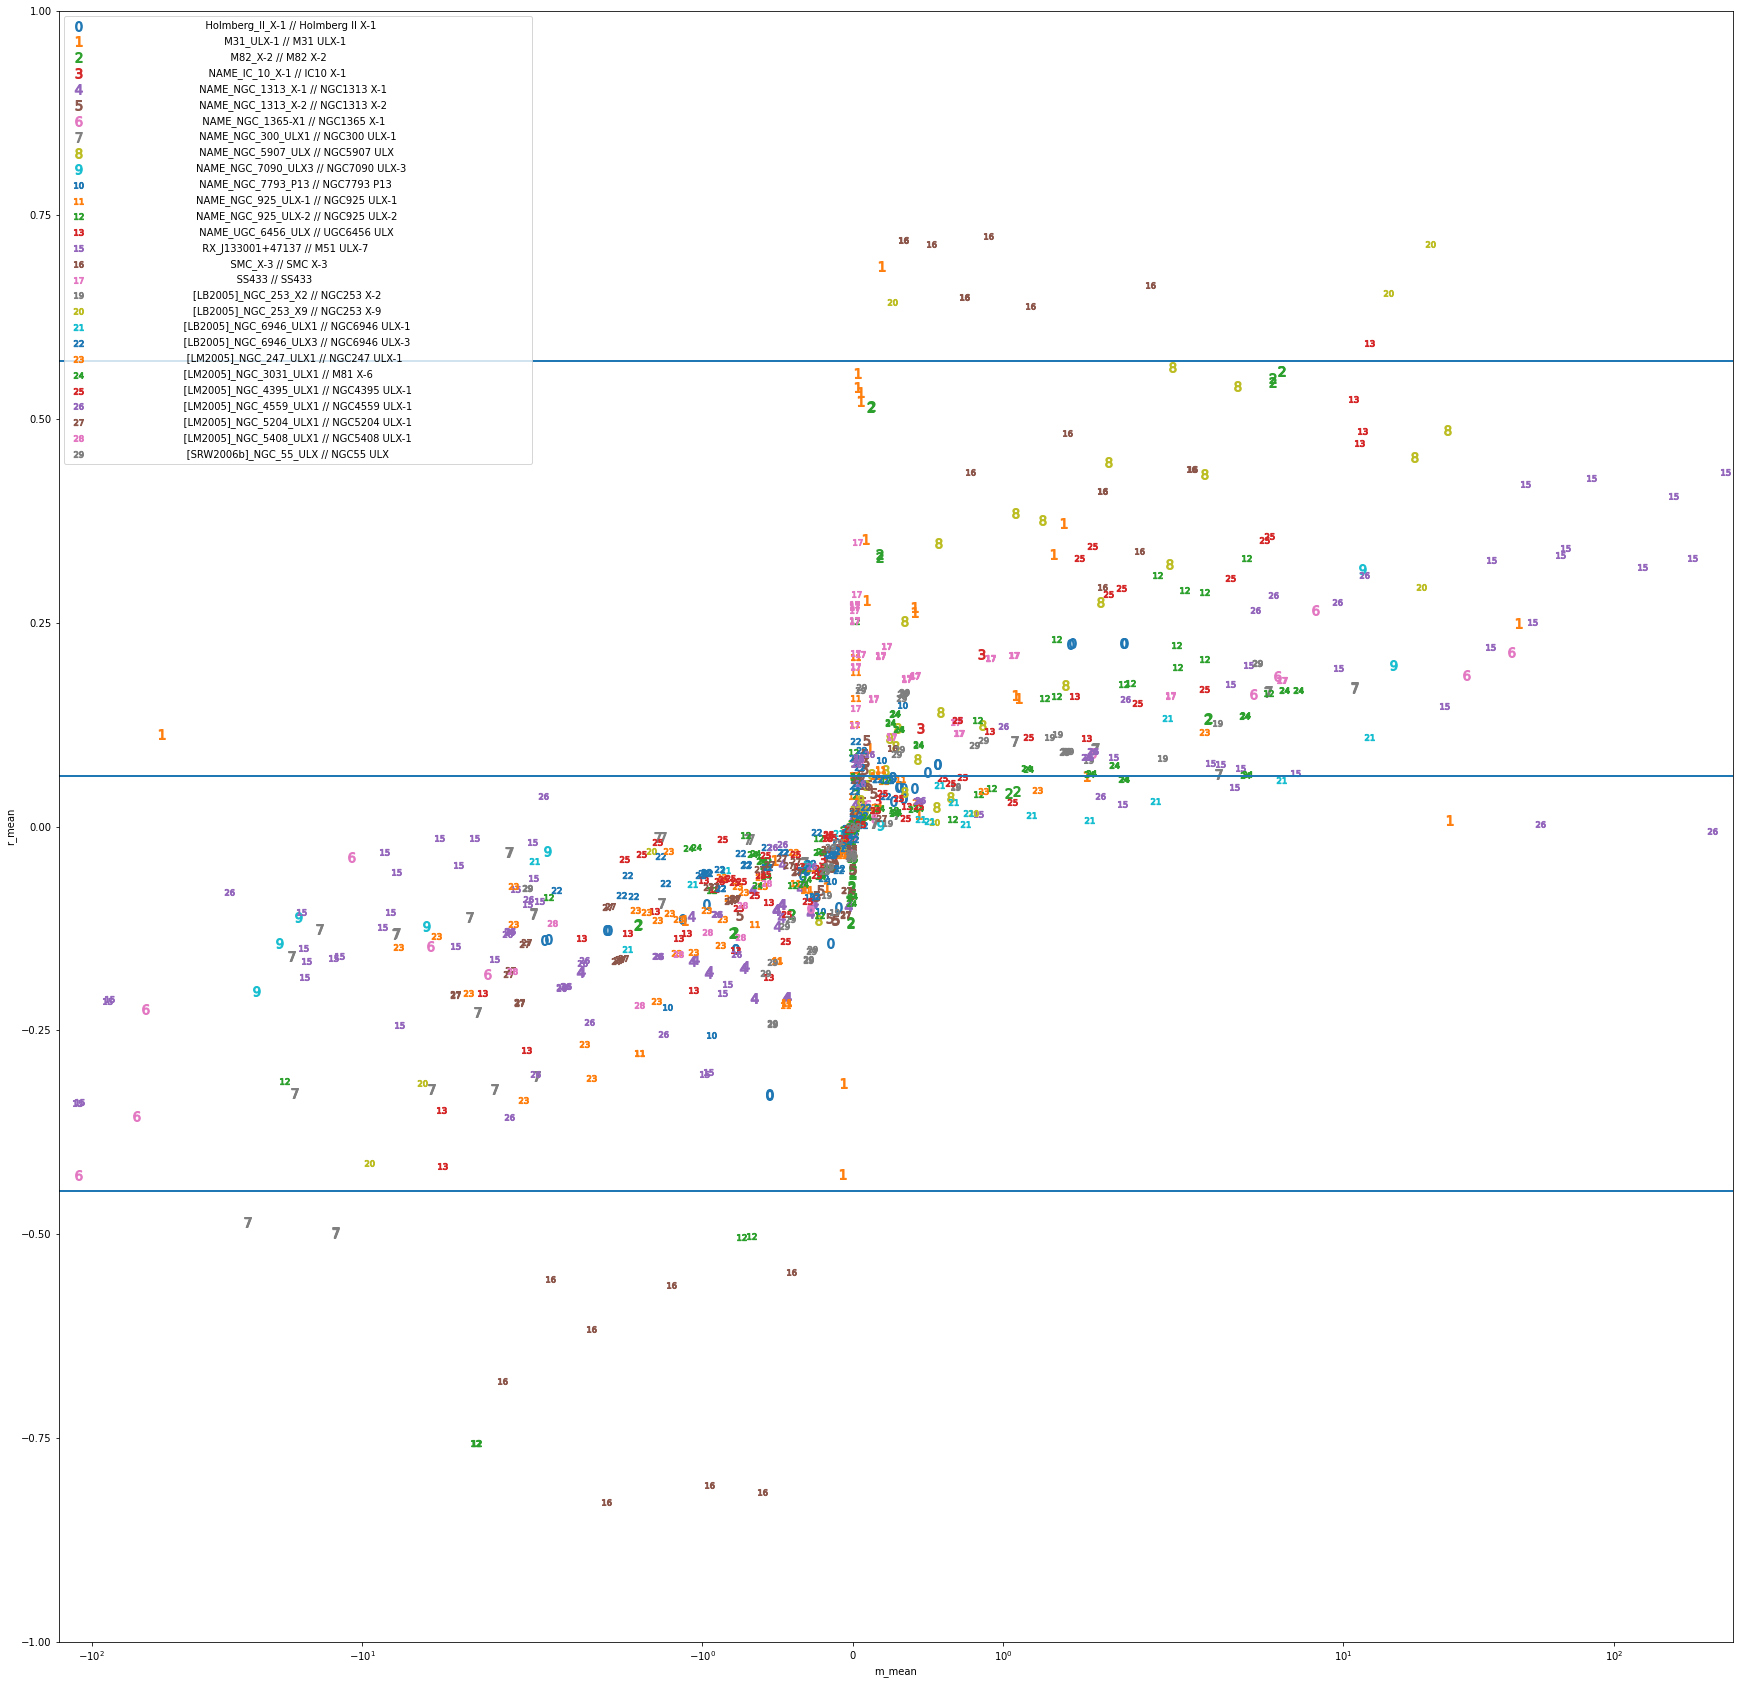

In [52]:
exclude = ['SWIFT_J0243.6+6124', 'NOVA_Cyg_1989']

nsig     = 2
r_mu     = df['r_mean'].mean()
r_std    = df['r_mean'].std()
r_sig_up = r_mu + nsig*r_std
r_sig_lo = r_mu - nsig*r_std


plt.figure(figsize=(30,30), facecolor='white')
for i, s in enumerate(df['simbad_name'].unique()):
    if s in exclude:
        continue
    sub = df[df['simbad_name'] == s]
    sub2 = sub[(sub['r_mean'] > r_sig_up) & (sub['r_mean'] < r_sig_lo)]
    plt.scatter(sub['m_mean'], sub['r_mean'], marker=f'${i}$', label=f'{s:>50} // {source_names_readable[s]:<50}', s=100)
    plt.axhline(r_mu)
    plt.axhline(r_sig_up)
    plt.axhline(r_sig_lo)
    
    #plt.errorbar(sub['m_mean'], sub['r_mean'], xerr=sub['m_std'], yerr=sub['r_std'], marker=f'${i}$', label=s, markersize=10)
plt.xlabel('m_mean')
plt.ylabel('r_mean')

plt.xscale('symlog')
plt.ylim(-1,1)
#plt.xlim(-10,10)
plt.legend()
#plt.ylim(-10,10)


In [49]:
df

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std
0,Holmberg_II_X-1,FULL,U,False,False,0.060790,0.035143,0.262742,0.152084,4.581733,0.025354
1,Holmberg_II_X-1,FULL,U,False,True,0.223747,0.050548,1.445039,0.531554,4.362411,0.097665
2,Holmberg_II_X-1,FULL,U,True,False,0.060671,0.035561,0.262324,0.153964,4.581791,0.025517
3,Holmberg_II_X-1,FULL,U,True,True,0.224846,0.049680,1.456770,0.530538,4.360249,0.097472
4,Holmberg_II_X-1,FULL,UVM2,False,False,-0.028258,0.078480,-0.114649,0.305283,2.070258,0.060918
...,...,...,...,...,...,...,...,...,...,...,...
1014,[SRW2006b]_NGC_55_ULX,SOFT,UVM2,True,False,0.088633,0.150098,0.286430,0.488772,0.295750,0.020857
1015,[SRW2006b]_NGC_55_ULX,SOFT,UVW1,False,False,-0.025397,0.083256,-0.152800,0.513456,0.597235,0.024708
1016,[SRW2006b]_NGC_55_ULX,SOFT,UVW1,True,False,-0.019086,0.081635,-0.108179,0.475556,0.594623,0.022619
1017,[SRW2006b]_NGC_55_ULX,SOFT,UVW2,False,False,-0.166631,0.106321,-0.534569,0.349669,0.490887,0.016000


In [53]:
sub_3sig = df[(df['r_mean'] > r_sig_up) | (df['r_mean'] < r_sig_lo)]
sub_3sig

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std
52,M31_ULX-1,FULL,UVW2,True,False,0.687030,0.230579,0.189701,0.089338,0.106732,0.007050
226,NAME_NGC_300_ULX1,FULL,B,False,False,-0.484873,0.026835,-26.661699,2.104958,8.427032,0.146476
228,NAME_NGC_300_ULX1,FULL,B,True,False,-0.484714,0.026467,-26.642606,2.071403,8.427117,0.143570
246,NAME_NGC_300_ULX1,FULL,V,False,False,-0.497688,0.033453,-12.599503,1.150082,4.267684,0.083618
248,NAME_NGC_300_ULX1,FULL,V,True,False,-0.498104,0.033238,-12.619402,1.139924,4.269468,0.084422
...,...,...,...,...,...,...,...,...,...,...,...
645,SWIFT_J0243.6+6124,SOFT,V,False,False,0.748563,0.030185,0.099773,0.010368,85.772280,0.248150
646,SWIFT_J0243.6+6124,SOFT,V,True,False,0.722862,0.030794,0.096339,0.009795,86.013787,0.227068
657,[LB2005]_NGC_253_X9,FULL,U,False,False,0.654443,0.251583,14.593624,7.599538,2.702508,0.186617
661,[LB2005]_NGC_253_X9,HARD,U,False,False,0.714277,0.214225,20.938038,9.840649,2.786064,0.131517


In [10]:
df_merge = pd.merge(df, df_ndata, how='left', left_on=['simbad_name', 'xrt_curve', 'uvot_filter'], right_on=['simbad_name', 'xrt_curve', 'uvot_filter'])

In [11]:
df_merge['readable_name']= df_merge['simbad_name'].map(source_names_readable)

In [12]:
df_merge.sort_values('ndata', ascending=False)

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std,ndata,readable_name
16,Holmberg_II_X-1,HARD,U,False,False,0.035132,0.039454,0.334331,0.375806,4.604838,0.024394,0.0,Holmberg II X-1
590,SS433,SOFT,B,True,False,0.161008,0.063749,2.300521,0.915092,13.243012,0.364221,0.0,SS433
632,SWIFT_J0243.6+6124,HARD,UVW2,True,False,0.646333,0.054566,0.000266,0.000027,4.365098,0.014035,0.0,Swift J0243.6+6124
631,SWIFT_J0243.6+6124,HARD,UVW2,False,False,0.650829,0.056576,0.000261,0.000027,4.364994,0.015038,0.0,Swift J0243.6+6124
630,SWIFT_J0243.6+6124,HARD,UVW1,True,False,0.763238,0.024125,0.001023,0.000058,13.251828,0.030532,0.0,Swift J0243.6+6124
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,[SRW2006b]_NGC_55_ULX,SOFT,UVM2,True,False,0.088633,0.150098,0.286430,0.488772,0.295750,0.020857,NaN,NGC55 ULX
1015,[SRW2006b]_NGC_55_ULX,SOFT,UVW1,False,False,-0.025397,0.083256,-0.152800,0.513456,0.597235,0.024708,NaN,NGC55 ULX
1016,[SRW2006b]_NGC_55_ULX,SOFT,UVW1,True,False,-0.019086,0.081635,-0.108179,0.475556,0.594623,0.022619,NaN,NGC55 ULX
1017,[SRW2006b]_NGC_55_ULX,SOFT,UVW2,False,False,-0.166631,0.106321,-0.534569,0.349669,0.490887,0.016000,NaN,NGC55 ULX


In [13]:
df_merge_sub = df_merge[df_merge['ndata'] > 30]
df_merge_sub.sort_values('readable_name', ascending=False)

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std,ndata,readable_name


(<matplotlib.patches.Rectangle at 0x7f0a08894a90>,
 (<matplotlib.patches.ConnectionPatch at 0x7f0a076e34f0>,
  <matplotlib.patches.ConnectionPatch at 0x7f0a0770c460>))

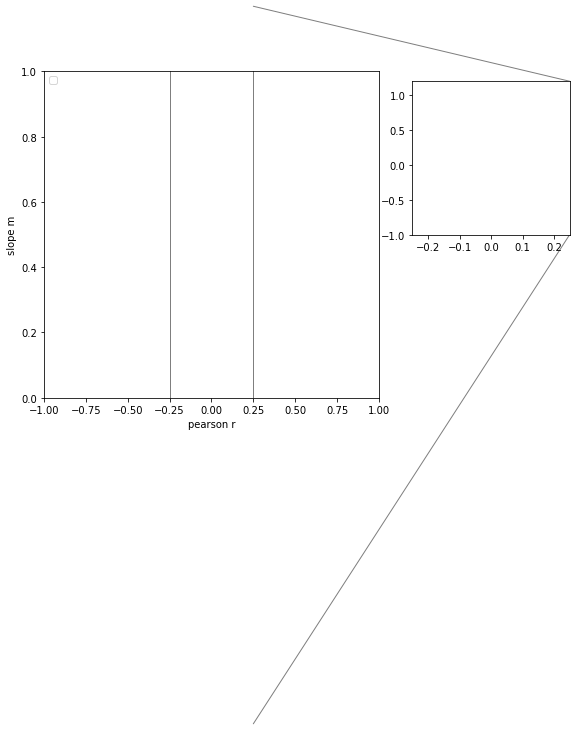

In [14]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots(1,1, figsize=(6,6))
axins = ax.inset_axes([1.1,0.5,0.47,0.47])
for n in np.unique(df_merge_sub['readable_name']):
    sub = df_merge_sub[df_merge_sub['xrt_curve'] != 'HR']
    sub = df_merge_sub[df_merge_sub['readable_name'] == n]
    ax.errorbar(sub['r_mean'], sub['m_mean'], xerr=sub['r_std'], yerr=sub['m_std'], ls='none', capsize=1.0, lw=1.0, label=n)
    axins.errorbar(sub['r_mean'], sub['m_mean'], xerr=sub['r_std'], yerr=sub['m_std'], ls='none', capsize=1.0, lw=1.0, label=n)
ax.set_xlabel('pearson r')
ax.set_ylabel('slope m')
#plt.ylim(-10,10)
ax.set_xlim(-1,1)
ax.legend()
axins.set_xlim(-0.25, 0.25)
axins.set_ylim(-1, 1.2)
ax.indicate_inset_zoom(axins, edgecolor="black")

#plt.ylim(-10,10)

In [15]:
df_merge_sub = df_merge_sub.round(2)

In [16]:
df_merge_sub['r_tex'] = df_merge_sub['r_mean'].astype('str') + ' $\pm$ ' +  df_merge_sub['r_std'].astype('str')
df_merge_sub['m_tex'] = df_merge_sub['m_mean'].astype('str') + ' $\pm$ ' +  df_merge_sub['m_std'].astype('str')
df_merge_sub['c_tex'] = df_merge_sub['c_mean'].astype('str') + ' $\pm$ ' +  df_merge_sub['c_std'].astype('str')


In [17]:
sub = df_merge_sub[['readable_name', 'xrt_curve', 'uvot_filter', 'ndata', 'r_tex', 'm_tex', 'c_tex']]


sub.sort_values(['readable_name', 'xrt_curve', 'uvot_filter'], ascending=False).to_latex('../tables/correlations_tab.tex', escape=False, index=False)

/tmp/ipykernel_1911/199394882.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  sub.sort_values(['readable_name', 'xrt_curve', 'uvot_filter'], ascending=False).to_latex('../tables/correlations_tab.tex', escape=False, index=False)


In [18]:
sub.sort_values(['readable_name', 'xrt_curve', 'uvot_filter'], ascending=False)

,readable_name,xrt_curve,uvot_filter,ndata,r_tex,m_tex,c_tex


In [19]:
from astropy.table import Table

In [20]:
df.sort_values('r_mean')

,simbad_name,xrt_curve,uvot_filter,include_bad,include_UL,r_mean,r_std,m_mean,m_std,c_mean,c_std
547,SMC_X-3,SOFT,UVW1,False,False,-0.828462,0.050895,-1.638996,0.190555,45.867776,0.257805
531,SMC_X-3,FULL,UVW1,False,False,-0.815798,0.055071,-0.605504,0.071976,45.912659,0.264377
539,SMC_X-3,HARD,UVW1,False,False,-0.806928,0.058735,-0.954235,0.116361,45.933129,0.263839
366,NAME_NGC_925_ULX-2,FULL,U,True,True,-0.756465,0.203363,-3.853175,3.751091,2.219646,0.054662
364,NAME_NGC_925_ULX-2,FULL,U,False,True,-0.755465,0.238954,-3.813000,5.320390,2.190914,0.137041
...,...,...,...,...,...,...,...,...,...,...,...
450,NOVA_Cyg_1989,HARD,UVW1,True,False,0.818179,0.010710,0.008343,0.000264,1.096278,0.031381
429,NOVA_Cyg_1989,FULL,UVW1,False,False,0.824288,0.010157,0.006533,0.000090,0.764621,0.021517
430,NOVA_Cyg_1989,FULL,UVW1,False,True,0.825056,0.010220,0.006553,0.000096,0.745173,0.042909
431,NOVA_Cyg_1989,FULL,UVW1,True,False,0.826070,0.010053,0.006569,0.000091,0.728394,0.020918
